## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [195]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [196]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

from pathlib import Path
from tempfile import NamedTemporaryFile
from sklearn.metrics import precision_score, recall_score, roc_auc_score, mean_absolute_error, confusion_matrix



In [197]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [198]:
file_path = Path("/mnt/c/Users/Adriana/Desktop/ZRIVE/data/financials_against_return.feather")
data_set = pd.read_feather(file_path)
data_set.head()

Ticker       date  AssetTurnover  CashFlowFromFinancialActivities  \
0      A 2005-01-31         0.1695                           81.000   
1   NDSN 2005-01-31         0.2248                           -3.366   
2   HURC 2005-01-31         0.3782                            0.483   
3    NRT 2005-01-31         1.0517                              NaN   
4    HRL 2005-01-31         0.4880                          -12.075   

   CashFlowFromInvestingActivities  CashFlowFromOperatingActivities  \
0                          -57.000                          137.000   
1                           10.663                            7.700   
2                           -0.400                            2.866   
3                              NaN                              NaN   
4                         -113.077                           83.476   

   CashOnHand  ChangeInAccountsPayable  ChangeInAccountsReceivable  \
0   2483.0000                    5.000                      44.000   
1     62.6220                      NaN                         NaN   
2     11.3030                    0.156                       0.854   
3      4.9015                      NaN                         NaN   
4    145.2050                      NaN                      17.084   

   ChangeInAssetsLiabilities  ...  EBIT_change_2_years  \
0                     -5.000  ...                  NaN   
1                    -21.145  ...                  NaN   
2                     -0.027  ...                  NaN   
3                        NaN  ...                  NaN   
4                      3.539  ...                  NaN   

   Revenue_change_1_years  Revenue_change_2_years  NetCashFlow_change_1_years  \
0                     NaN                     NaN                         NaN   
1                     NaN                     NaN                         NaN   
2                     NaN                     NaN                         NaN   
3                     NaN                     NaN                         NaN   
4                     NaN                     NaN                         NaN   

   NetCashFlow_change_2_years  CurrentRatio_change_1_years  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                         NaN                          NaN   

   CurrentRatio_change_2_years  Market_cap__minus_365  Market_cap__minus_730  \
0                          NaN                    NaN                    NaN   
1                          NaN                    NaN                    NaN   
2                          NaN                    NaN                    NaN   
3                          NaN                    NaN                    NaN   
4                          NaN                    NaN                    NaN   

   diff_ch_sp500  
0       0.304773  
1       0.387846  
2       0.543440  
3       0.331322  
4       0.218482  

[5 rows x 144 columns]

Remove the quarters which have less than `minimum_number_of_tickers` tickers:

In [199]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [200]:
data_set.shape

(170483, 145)

Create the target:

In [201]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [202]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [203]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [204]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

By examining the code, we can see that the target variable is calculated by subtracting sp500_change_365 from stock_change_div_365. If the difference is greater than 0, the target is set to 1; otherwise, it is set to 0. Therefore, the **features used to compute the target** (stock_change_div_365 and sp500_change_365) **should be removed to prevent data leakage**, as they provide direct information about the target variable.

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [205]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [206]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None
    
    # if both train and test are not empty
    if train_size > 0 and test_size>0:
        model, evals_result, X_train, X_test = train_model(train_set,
                                                            test_set,
                                                            n_estimators = n_estimators)
        
        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending = False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test

In [207]:
execution_dates = np.sort( data_set['execution_date'].unique() )

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [208]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")

    else:
        print(f"No model returned for execution date: {execution_date}")

all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
No model returned for execution date: 2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
No model returned for execution date: 2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
No model returned for execution date: 2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
No model returned for execution date: 2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
Model trained for execution date: 2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
Model trained for execution date: 2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
Model trained for execution date: 2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
Model trained for execution date: 2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
Model trained for execution date: 2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
Model trained for execution date: 2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
Model trained 

In [209]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [210]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [211]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


In [212]:
train_results_final_tree.head()

binary_logloss  weighted-return  n_trees execution_date
39        0.276797         0.277172       39     2006-06-30
39        0.393084         0.236828       39     2006-09-30
39        0.446241         0.288516       39     2006-12-30
39        0.479211         0.209679       39     2007-03-31
39        0.496369         0.222281       39     2007-06-30

And this are the results:

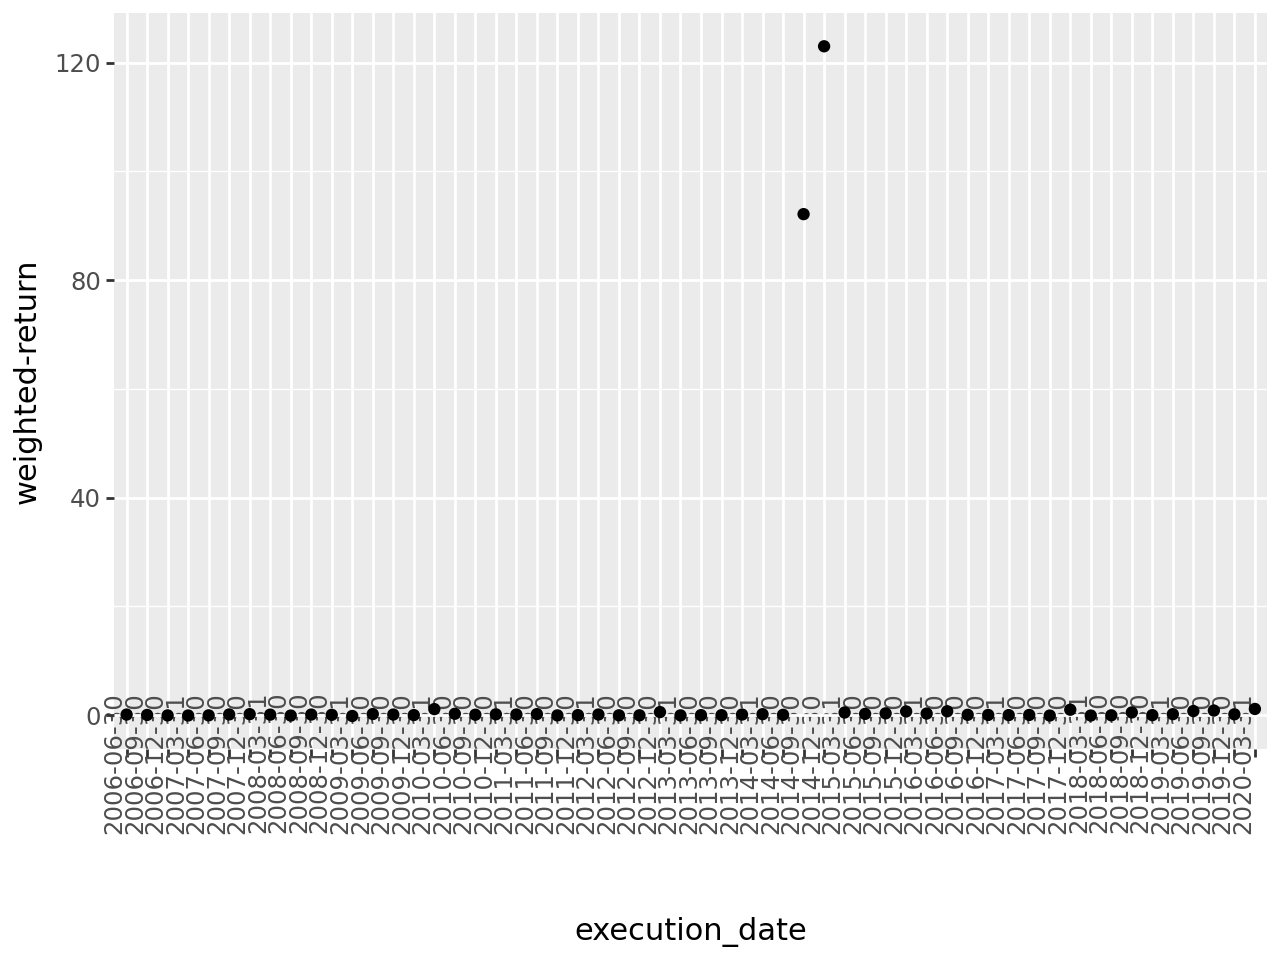

In [213]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

As we have two instances where the return is extremely high, we perform the plot without these two point to be able to see more clear the values of the other models.

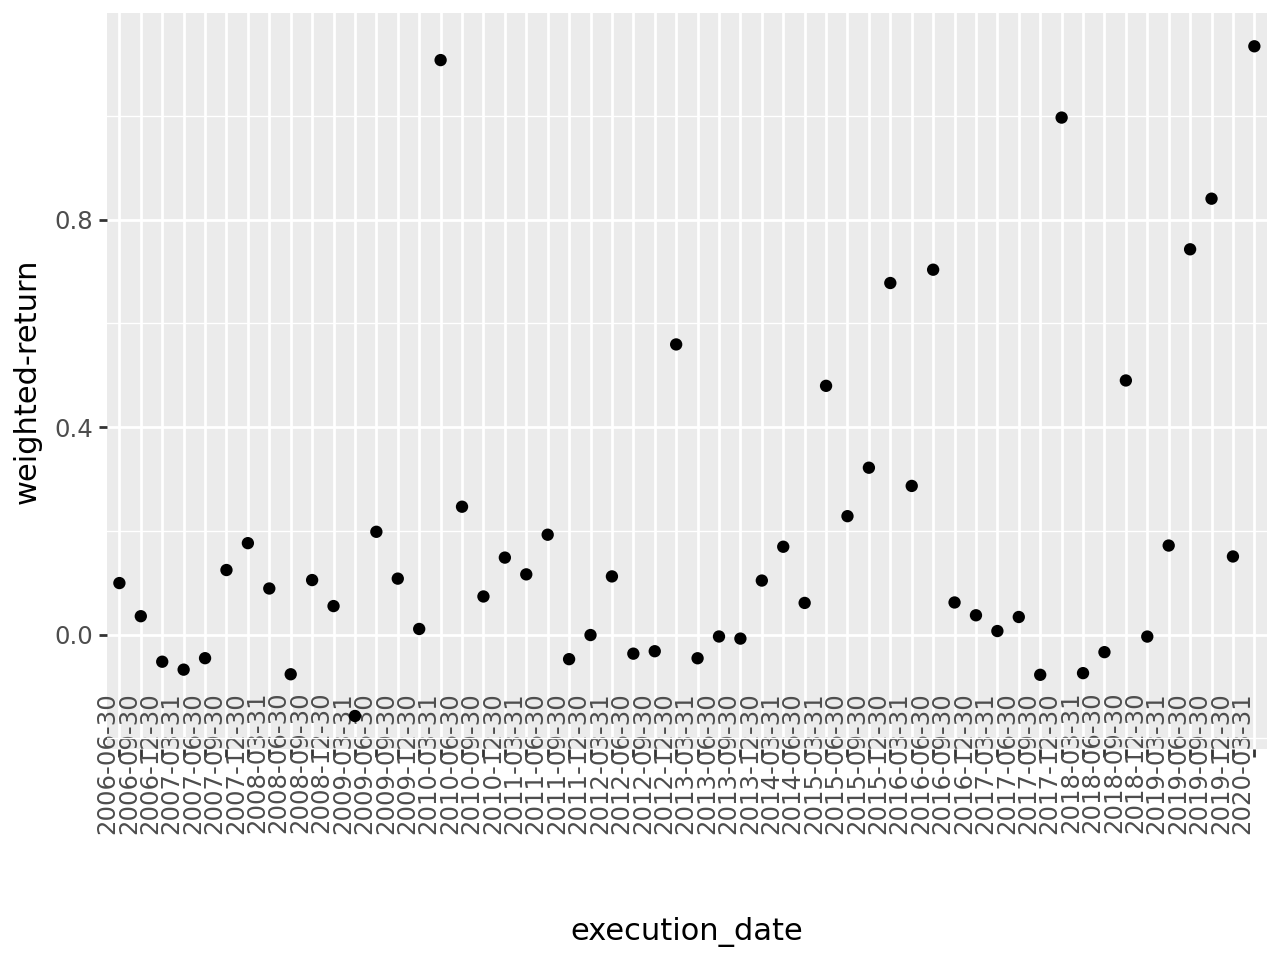

In [214]:
filtered_results = test_results_final_tree[test_results_final_tree["weighted-return"] < 80]
ggplot(filtered_results) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

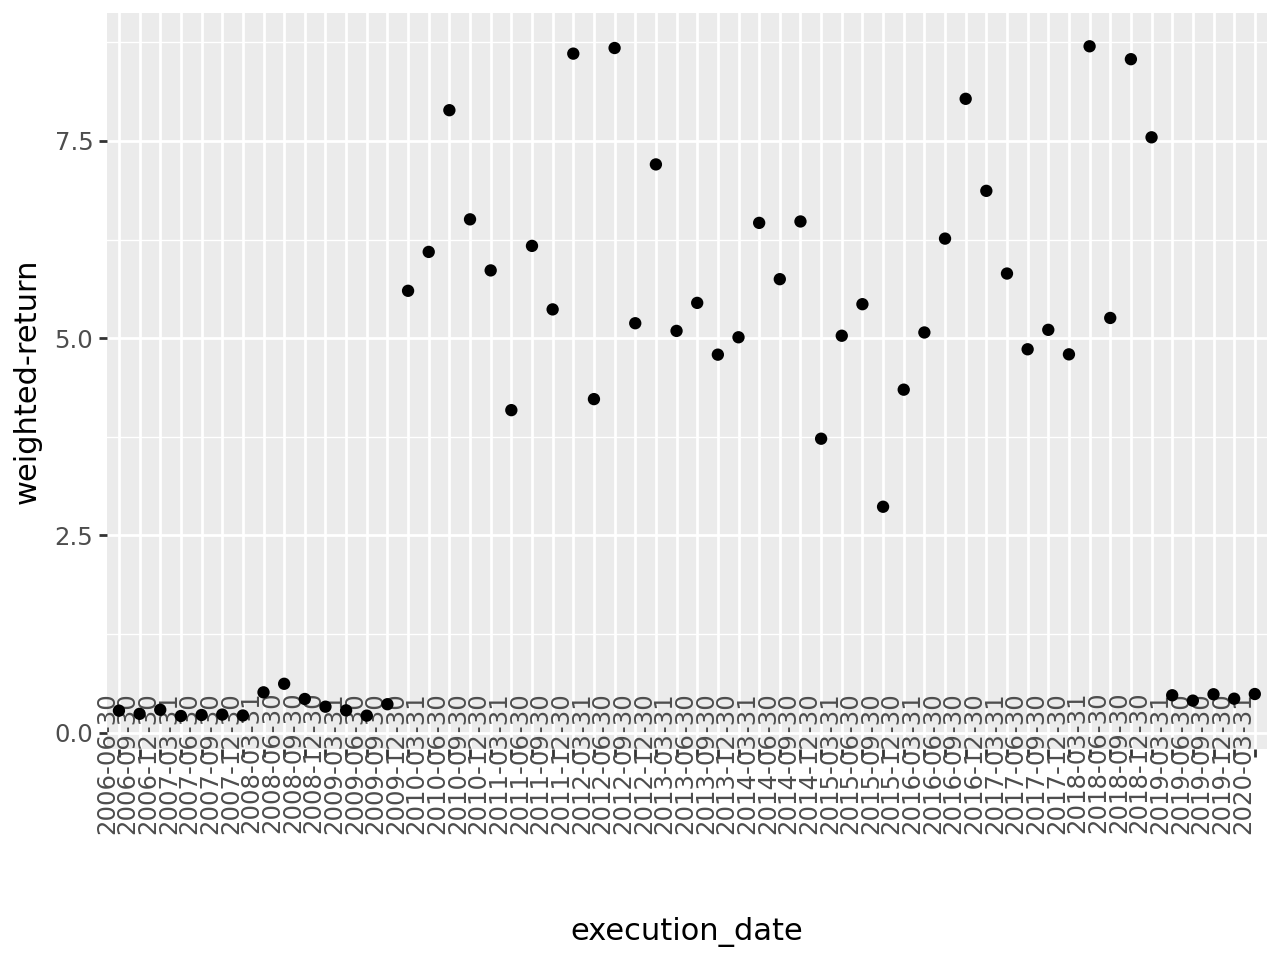

In [215]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We can observe that in test, most returns are around 0.3, but there are lots of points with retunrs higher than 0.4, and two execution dates: 2014-12 and 2015-03, which have a return of around 95 and 122 respectively, which is extremely high. On the other hand, in the train set, the maximum return less than 9, and the first and last dates have return near 0. For the middle execution dates, the return is distributed around 2.5 and 9. In general, the returns are higher than we would have expected, and we see a clear difference between the returns for train and for test.

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

#### 0. Define a benchmark model

First, it is important to create a simple benchmark model to compare the results of future models with it. This model will be average surplus of the sp500 of the top 500 stocks (those with higher market cap).

In [216]:
# Get top 500 stocks by market cap
data_set = data_set.sort_values(by=["execution_date", "Market_cap__minus_365"], ascending=[True, False])
top_500_stocks = data_set.groupby("execution_date").head(500)

# Calculate the average surplus over the SP500 for the top 500 stocks
benchmark_performance = top_500_stocks.groupby("execution_date").apply(
    lambda x: (x["stock_change_div_365"] - x["sp500_change_365"]).mean()
).reset_index(name="avg_surplus")

# Print the benchmark performance
print(benchmark_performance)


   execution_date  avg_surplus
0      2005-06-30     0.153672
1      2005-09-30     0.049984
2      2005-12-30     0.094732
3      2006-03-31     0.076128
4      2006-06-30     0.045679
..            ...          ...
59     2020-03-31     0.171367
60     2020-06-30          NaN
61     2020-09-30          NaN
62     2020-12-30          NaN
63     2021-03-27          NaN

[64 rows x 2 columns]


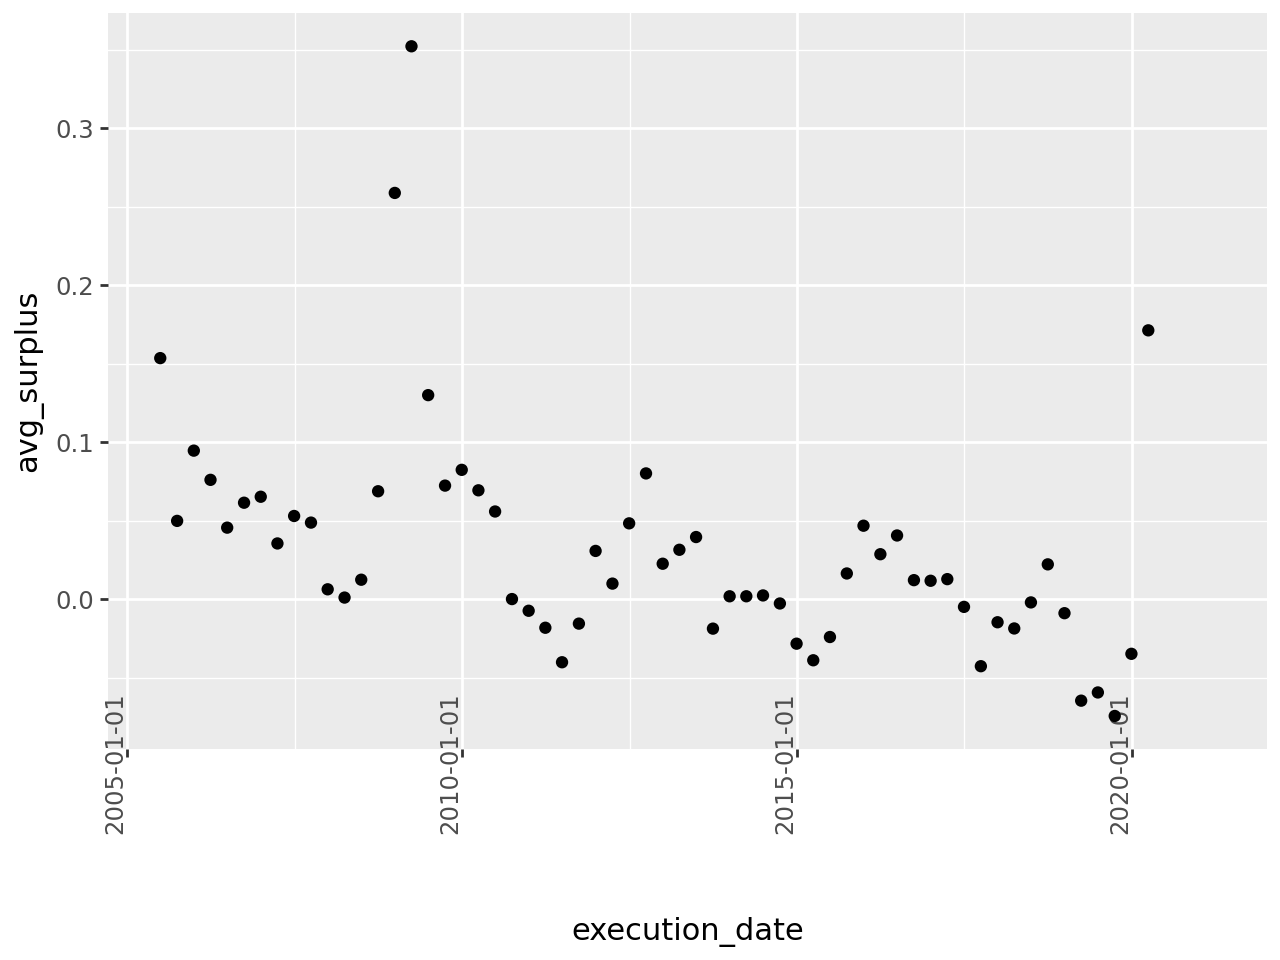

In [217]:
ggplot(benchmark_performance) + geom_point(aes(x = "execution_date", y = "avg_surplus")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

For better comparison, we can plot both returns together:

In [218]:
benchmark_performance['type'] = 'Benchmark'
filtered_results['type'] = 'Filtered'

benchmark_performance = benchmark_performance.rename(columns={'avg_surplus': 'weighted-return'})
filtered_results['execution_date'] = pd.to_datetime(filtered_results['execution_date'])

# Combine both
combined_data = pd.concat([
    benchmark_performance[['execution_date', 'weighted-return', 'type']],
    filtered_results[['execution_date', 'weighted-return', 'type']]
])

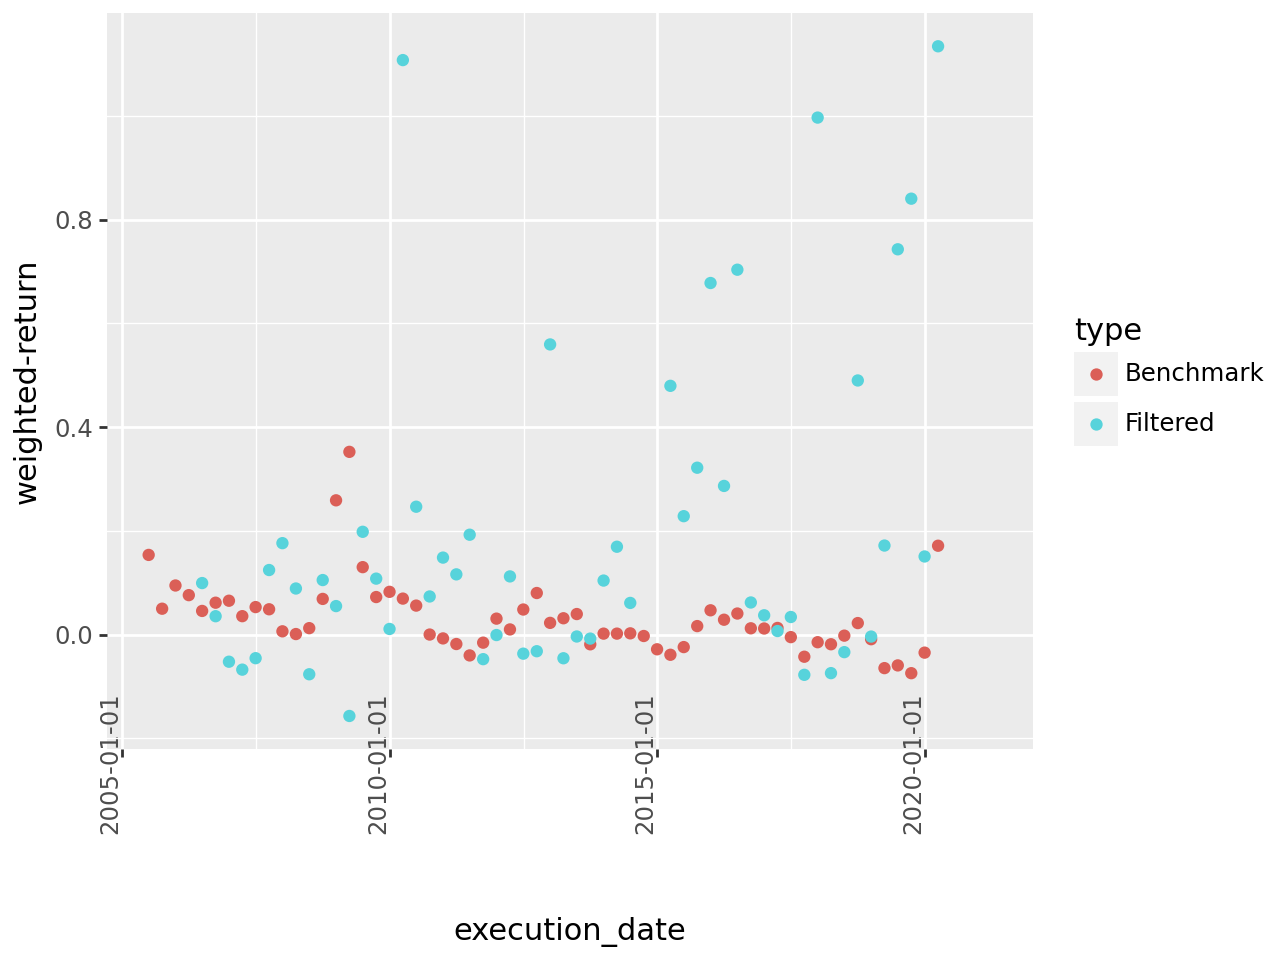

In [219]:
ggplot(combined_data) + geom_point(aes(x = "execution_date", y = "weighted-return", color='type')) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We can observe that the returns are quite lower than the ones from the model given, and much more reasonable.

This function can be useful to compute the feature importance:

In [220]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [221]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

#### 1. Try to see if there is any kind of data leakage or suspicious features
To diagnose if there is data leakage, we should usually:
- Look at feature importance and understand if the most important features make sense
- Retrain the model without suspicious features and see how much the performance decreases

And to solve it we should:
- Try to make a train/test split which resembles the production conditions
- Make sure that all the information that the model has in offline mode is going to be available in online too


Additionally, with the previous models, we perform feature importance:

In [222]:
plots = []
for execution_date, model in all_models.items():
    plot = draw_feature_importance(model, 15)
    plots.append(plot)

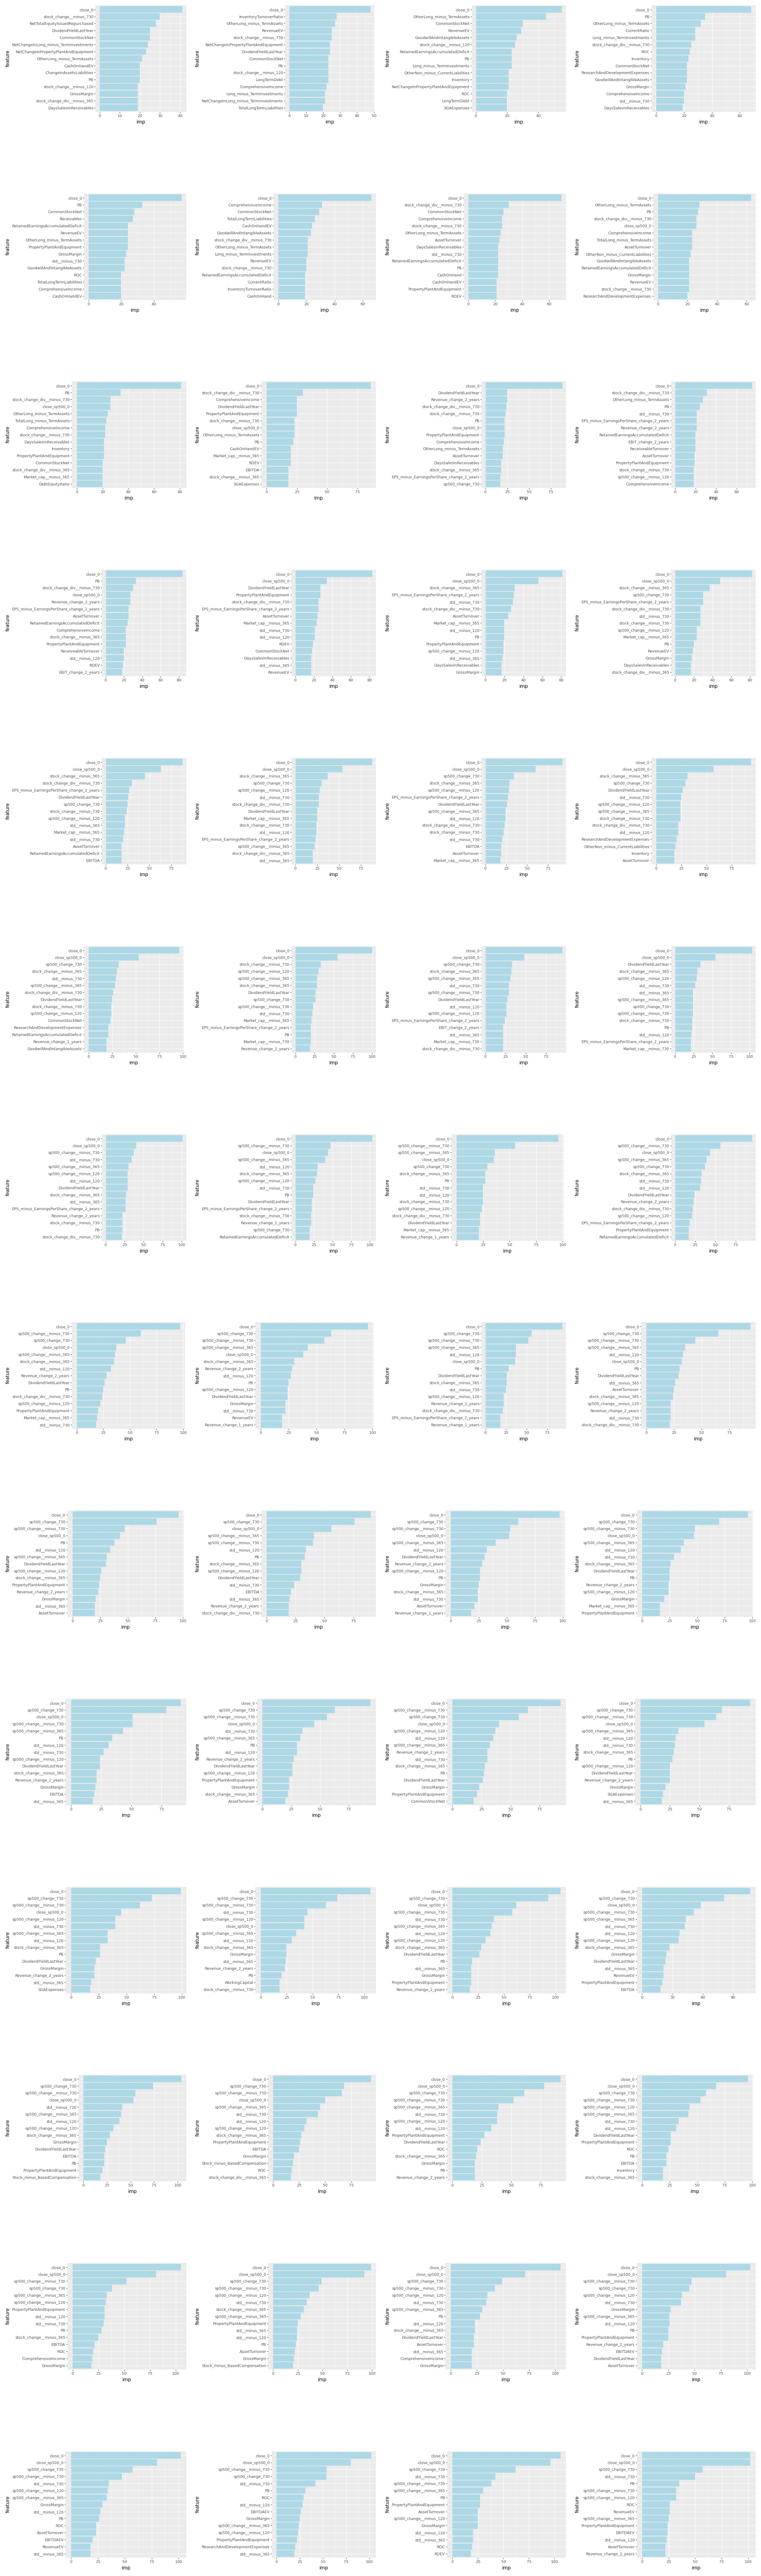

In [223]:
# Determine the number of rows and columns needed for the grid
ncols = 4
nrows = (len(plots) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5))

axes = axes.flatten()

# Plot each ggplot in the corresponding subplot
for ax, plot in zip(axes, plots):
    if plot is not None:
        with NamedTemporaryFile(suffix=".png") as tmpfile:
            plot.save(tmpfile.name, width=6, height=4, units='in', dpi=100)
            img = plt.imread(tmpfile.name)
            ax.imshow(img)
            ax.axis('off')
    else:
        ax.axis('off')

# Turn off any remaining empty subplots
for ax in axes[len(plots):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

We can observe that close_0 have abnormally high importance. It does not make sense that close_0 is the most important feature, as it represents what was the price at the moment of execution date. It would not make sense the idea of a model that basically defines whereas you should buy and action based on if the price is low or not.

It is worth mentioning that we should never trust the feature importance given by the trees, as it tends to give more importance to categorical features with a high number of categories. The more ideal approach for these cases is using permutation importance, which swaps columns and, if the performance degradates a lot, then the column is important.

I will retrain the model without these two suspicious features and without the previously removed features and see how much the model performance decreases:

In [224]:
data_set = data_set.drop(columns=['close_0'])

In [225]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")

    else:
        print(f"No model returned for execution date: {execution_date}")
        
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
No model returned for execution date: 2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
No model returned for execution date: 2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
No model returned for execution date: 2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
No model returned for execution date: 2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
Model trained for execution date: 2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
Model trained for execution date: 2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
Model trained for execution date: 2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
Model trained for execution date: 2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
Model trained for execution date: 2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
Model trained for execution date: 2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
Model trained 

In [226]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

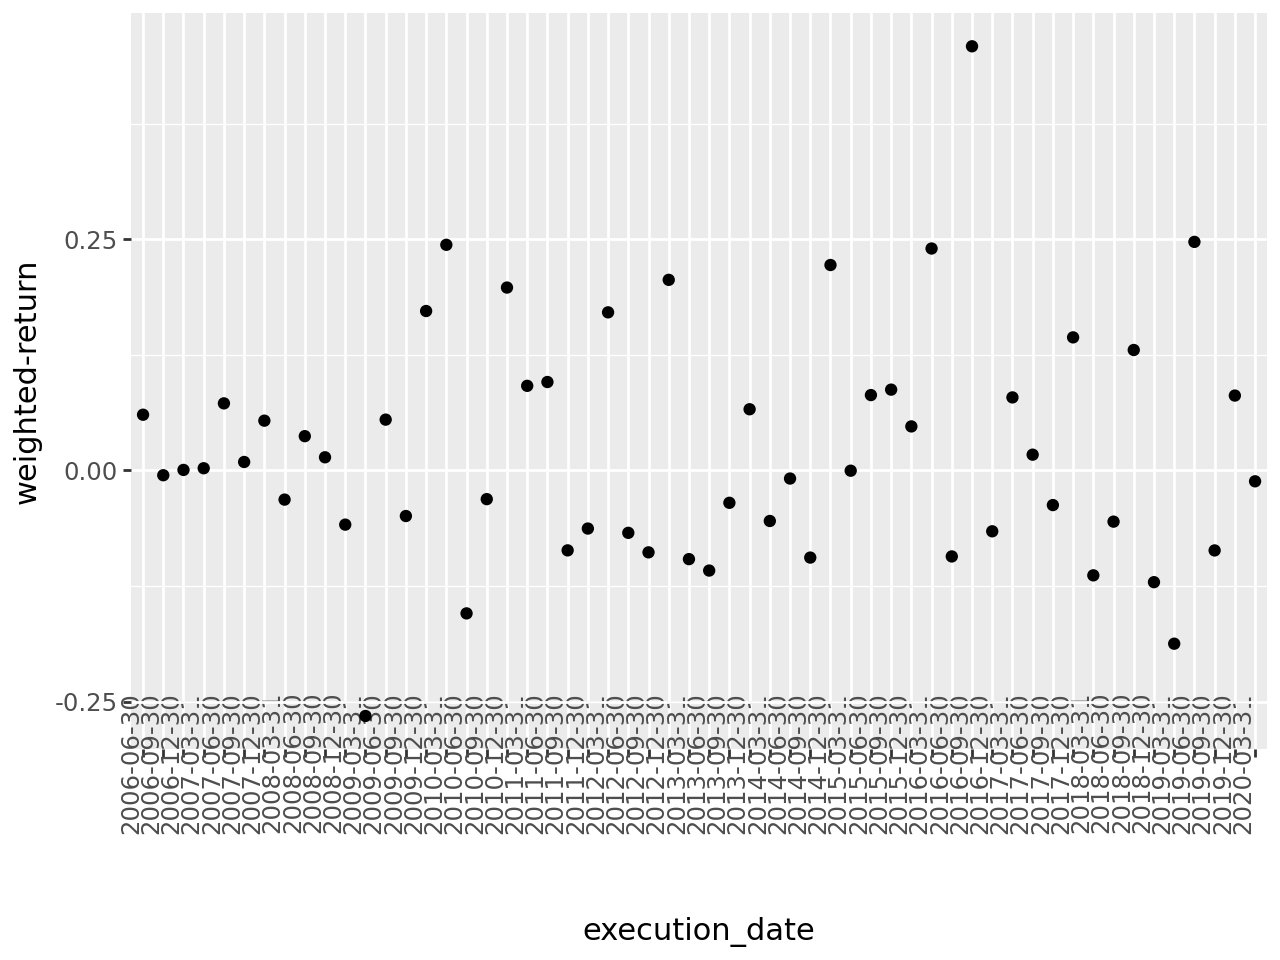

In [227]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

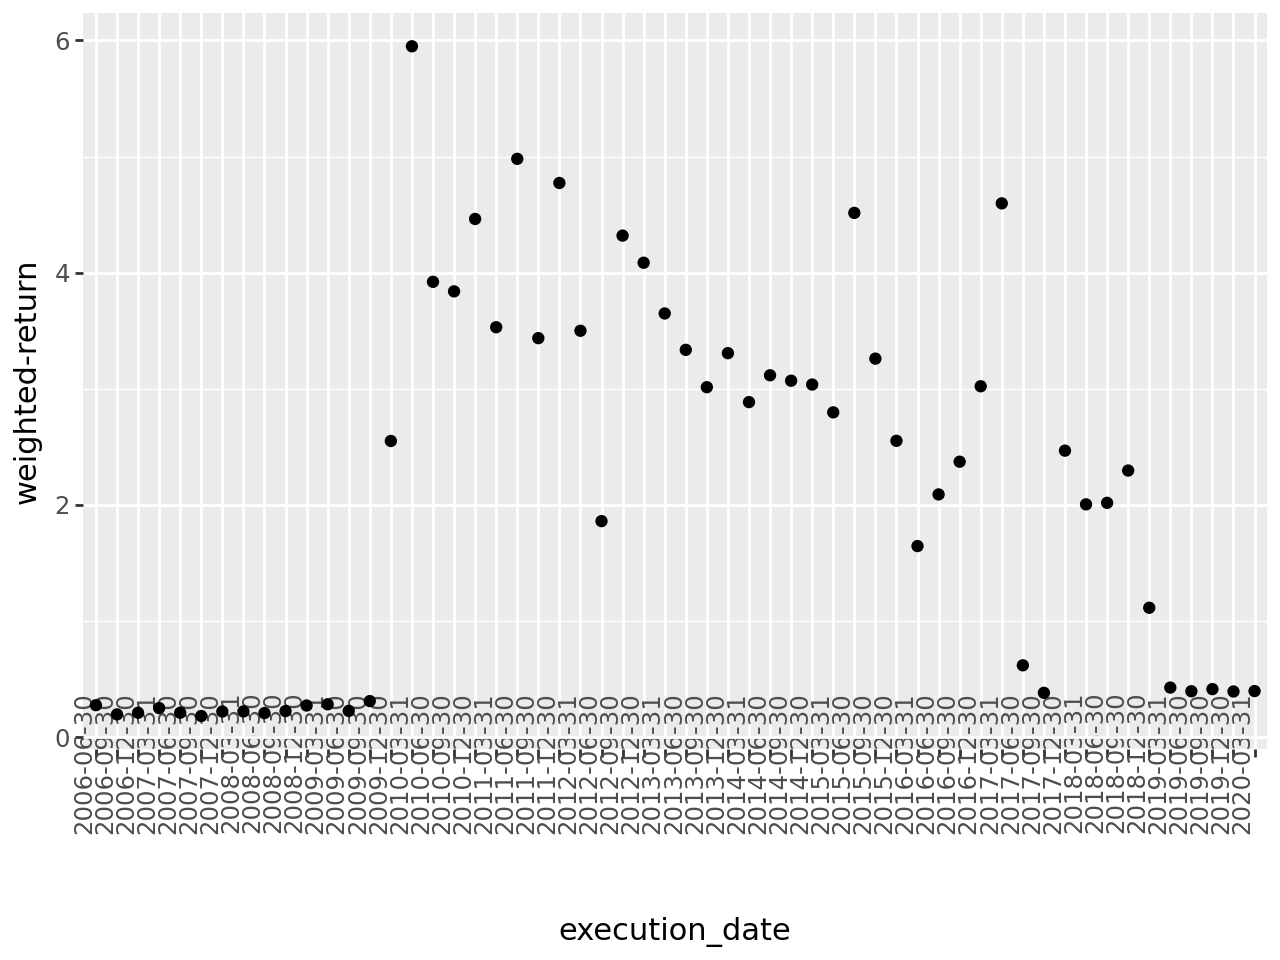

In [228]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

With this change, we can see that the training results were similar: initial and last execution dates have 0 return and the middle ones have return distributed with values from 0.75 to 5.5. On the other hand, in the test set, the return is centered around 0, and it looks like the variance increases for future dates. Additionally, we can observe that we have now negative returns. It is important to see that during training, there are several dates were the return is very high (with values higher than 2), whereas in validation the return is not higher than 0.4. Even though, these two values are still higher than we would expect.

#### 2. If the training part is very slow, try to see how you can modify it to execute faster tests
To speed up model training we could:
- Reduce the dataset size. This can also be helpful if the behaviour has changed over time, as the model could be using a distribution from the past that is not longer what represents the present.
- Optimize Hyperparameters: Adjust parameters such as max_depth, num_leaves, and learning_rate to balance performance and speed.
- Feature selection
- ...


To speed up the training we will take dates from 2008 onwards and we will only take 1 in every 4 periods:

In [229]:
last_past_date = 2008
print("Previous length of the dataset: ", len(data_set))
data_set = data_set[data_set['execution_date'].dt.year >= last_past_date]
print("Length of the dataset after filtering: ", len(data_set))
data_set = data_set[data_set.groupby(data_set['execution_date'].dt.to_period('Q')).ngroup() % 4 == 0]
print("Length of the dataset after second filtering: ", len(data_set))

Previous length of the dataset:  170483
Length of the dataset after filtering:  147674
Length of the dataset after second filtering:  38835


In [230]:
execution_dates = np.sort(data_set['execution_date'].unique() )

Then, I modify the baseline functions so that for each model feature importance is computed and then feature selection is performed to only keep those with importance higher than 0.

In [231]:
def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    
    # Add feature importance and selection
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    
    return model,eval_result,X_train,X_test, feature_importance

In [232]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
    global train_set
    global test_set
    global data_set  
    
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None
    importance_df = None

    
    # if both train and test are not empty
    if train_size > 0 and test_size>0:
        model, evals_result, X_train, X_test, importance_df = train_model(train_set,
                                                            test_set,
                                                            n_estimators = n_estimators)
        

        # Get the features with non-zero importance
        important_features = importance_df[importance_df['imp'] > 0]['feature'].tolist()

        # Filter train and test sets to keep only important features
        # Ensure 'target' and 'diff_ch_sp500' columns are present in train_set and test_set
        important_features.extend(['target', 'diff_ch_sp500'])
        
        train_set = train_set[important_features]
        test_set  = test_set [important_features]

        X_train = train_set.drop(columns=['target'])
        X_test = test_set.drop(columns=['target'])

        # Train the model again with filtered features
        model, evals_result, X_train, X_test, importance_df = train_model(train_set,test_set, n_estimators=n_estimators)
        
        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending = False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
        
    return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, test_set

In [233]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, test_set = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")

    else:
        print(f"No model returned for execution date: {execution_date}")
 
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
No model returned for execution date: 2008-03-31T00:00:00.000000000
2009-03-31T00:00:00.000000000
Model trained for execution date: 2009-03-31T00:00:00.000000000
2010-03-31T00:00:00.000000000
Model trained for execution date: 2010-03-31T00:00:00.000000000
2011-03-31T00:00:00.000000000
Model trained for execution date: 2011-03-31T00:00:00.000000000
2012-03-31T00:00:00.000000000
Model trained for execution date: 2012-03-31T00:00:00.000000000
2013-03-31T00:00:00.000000000
Model trained for execution date: 2013-03-31T00:00:00.000000000
2014-03-31T00:00:00.000000000
Model trained for execution date: 2014-03-31T00:00:00.000000000
2015-03-31T00:00:00.000000000
Model trained for execution date: 2015-03-31T00:00:00.000000000
2016-03-31T00:00:00.000000000
Model trained for execution date: 2016-03-31T00:00:00.000000000
2017-03-31T00:00:00.000000000
Model trained for execution date: 2017-03-31T00:00:00.000000000
2018-03-31T00:00:00.000000000
Model trained for executio

In [234]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

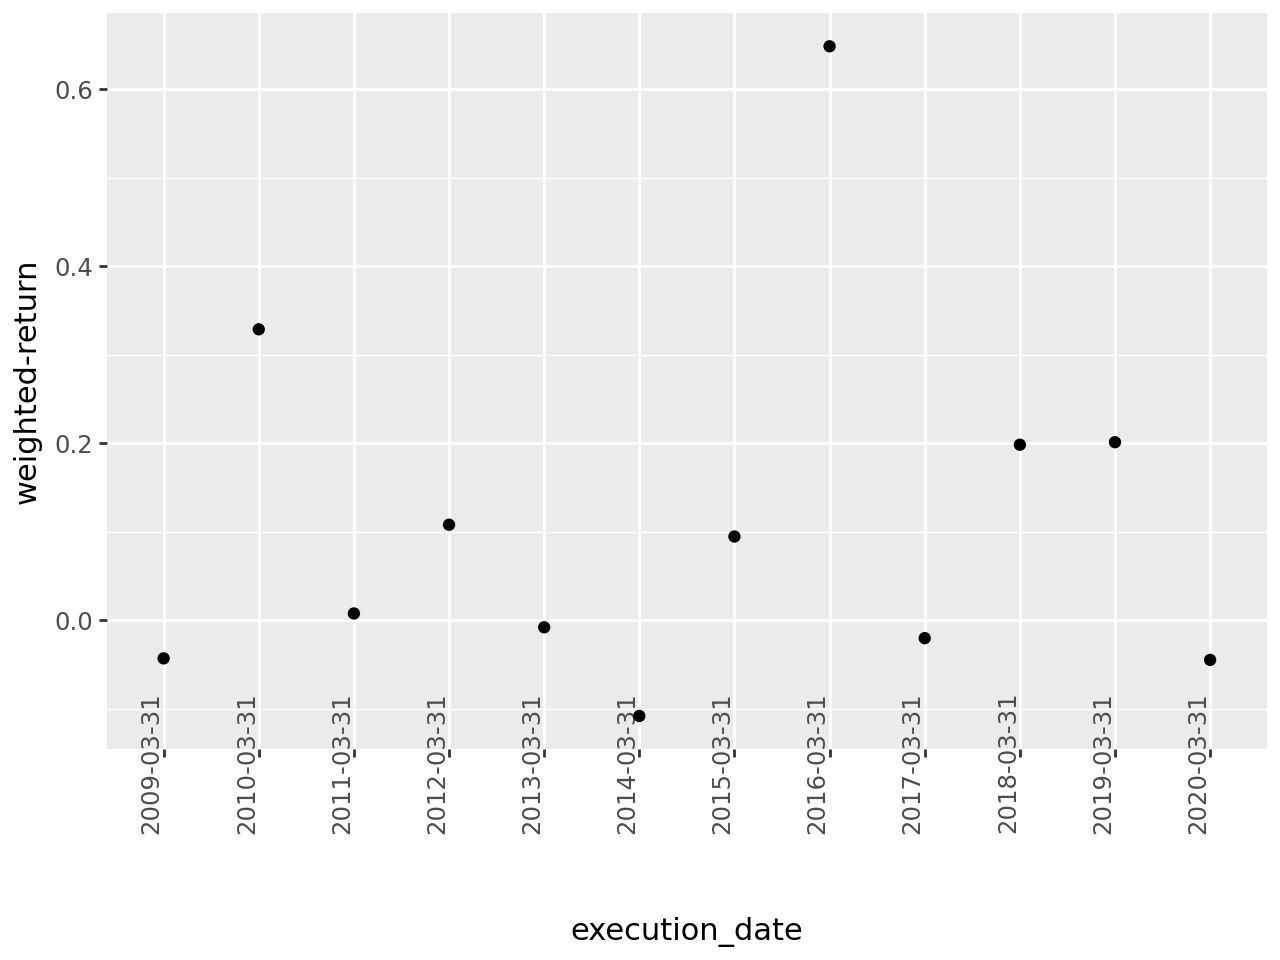

In [235]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

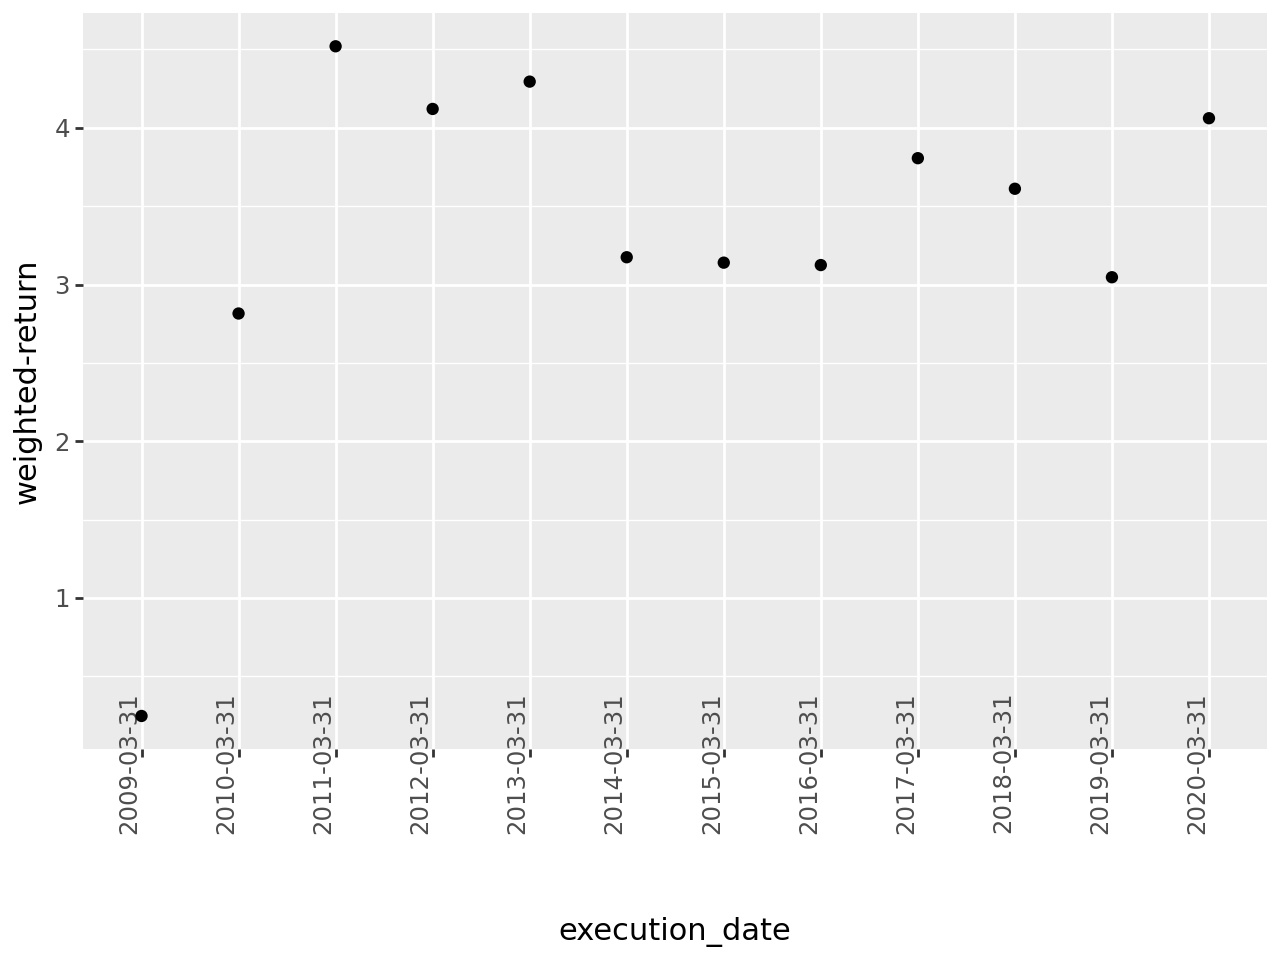

In [236]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We can observe that the returns are still not what we expect, so we will continue exploring.

#### 3 & 5. Try to understand if the algorithm is learning correctly & Try to see if there is overfitting

With the high overfitting and the extremely high returns we can interpret the model is not learning correctly. To try to solve the model, we will change the hyperparameters. We will reduce the learning rate, to make smaller steps and probe more through the space. Particularlly, for trees, the learning rate controls how much we are going to weight each new tree compared to previous ones. Additionally, we will also reduce the number of estimators to try to avoid the overfitting, as each estimator (tree) added to the model increases its complexity, and the model starts to fit the noise in the training data rather than the underlying pattern. 

In [237]:
n_trees = 20
learning_rate = 10e-3

As the learning rate is not explicitly set in the given functions, we modify them to include the learning rate parameter:

In [238]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators, learning_rate=0.1,include_nulls_in_test = False):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None
    
    # if both train and test are not empty
    if train_size > 0 and test_size>0:
        model, evals_result, X_train, X_test = train_model(train_set,
                                                            test_set,
                                                            n_estimators = n_estimators,
                                                            learning_rate = learning_rate)
        
        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending = False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, test_set

In [239]:
def train_model(train_set,test_set,n_estimators = 300, learning_rate=0.1):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "learning_rate": learning_rate,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

In [240]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, test_set = run_model_for_execution_date(execution_date,all_results,
                                                                                                                    all_predicted_tickers_list,
                                                                                                                    all_models,n_trees, learning_rate,
                                                                                                                    False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")

    else:
        print(f"No model returned for execution date: {execution_date}")
 
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
No model returned for execution date: 2008-03-31T00:00:00.000000000
2009-03-31T00:00:00.000000000
Model trained for execution date: 2009-03-31T00:00:00.000000000
2010-03-31T00:00:00.000000000
Model trained for execution date: 2010-03-31T00:00:00.000000000
2011-03-31T00:00:00.000000000
Model trained for execution date: 2011-03-31T00:00:00.000000000
2012-03-31T00:00:00.000000000
Model trained for execution date: 2012-03-31T00:00:00.000000000
2013-03-31T00:00:00.000000000
Model trained for execution date: 2013-03-31T00:00:00.000000000
2014-03-31T00:00:00.000000000
Model trained for execution date: 2014-03-31T00:00:00.000000000
2015-03-31T00:00:00.000000000
Model trained for execution date: 2015-03-31T00:00:00.000000000
2016-03-31T00:00:00.000000000
Model trained for execution date: 2016-03-31T00:00:00.000000000
2017-03-31T00:00:00.000000000
Model trained for execution date: 2017-03-31T00:00:00.000000000
2018-03-31T00:00:00.000000000
Model trained for executio

In [241]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

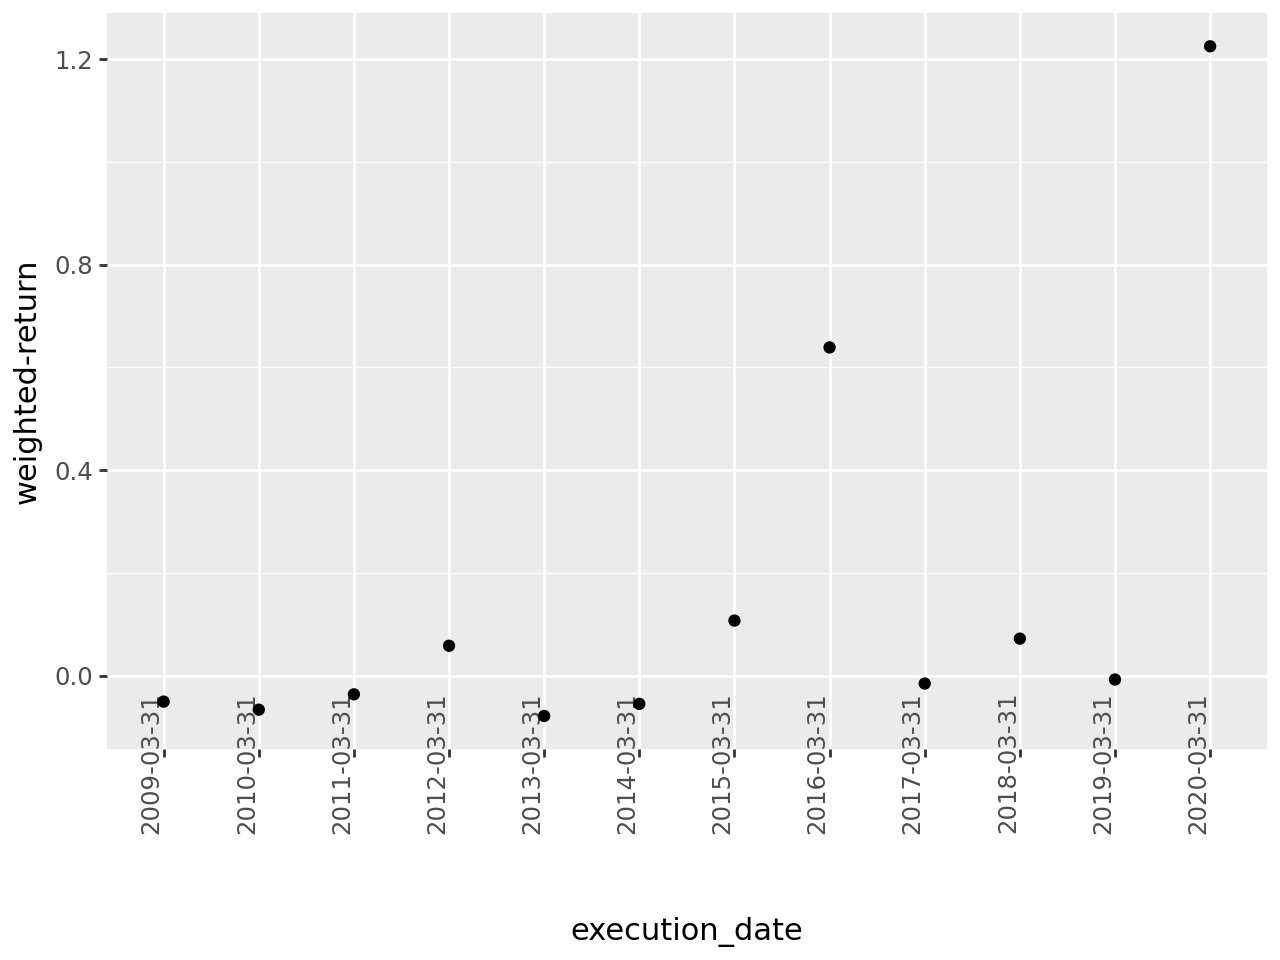

In [242]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

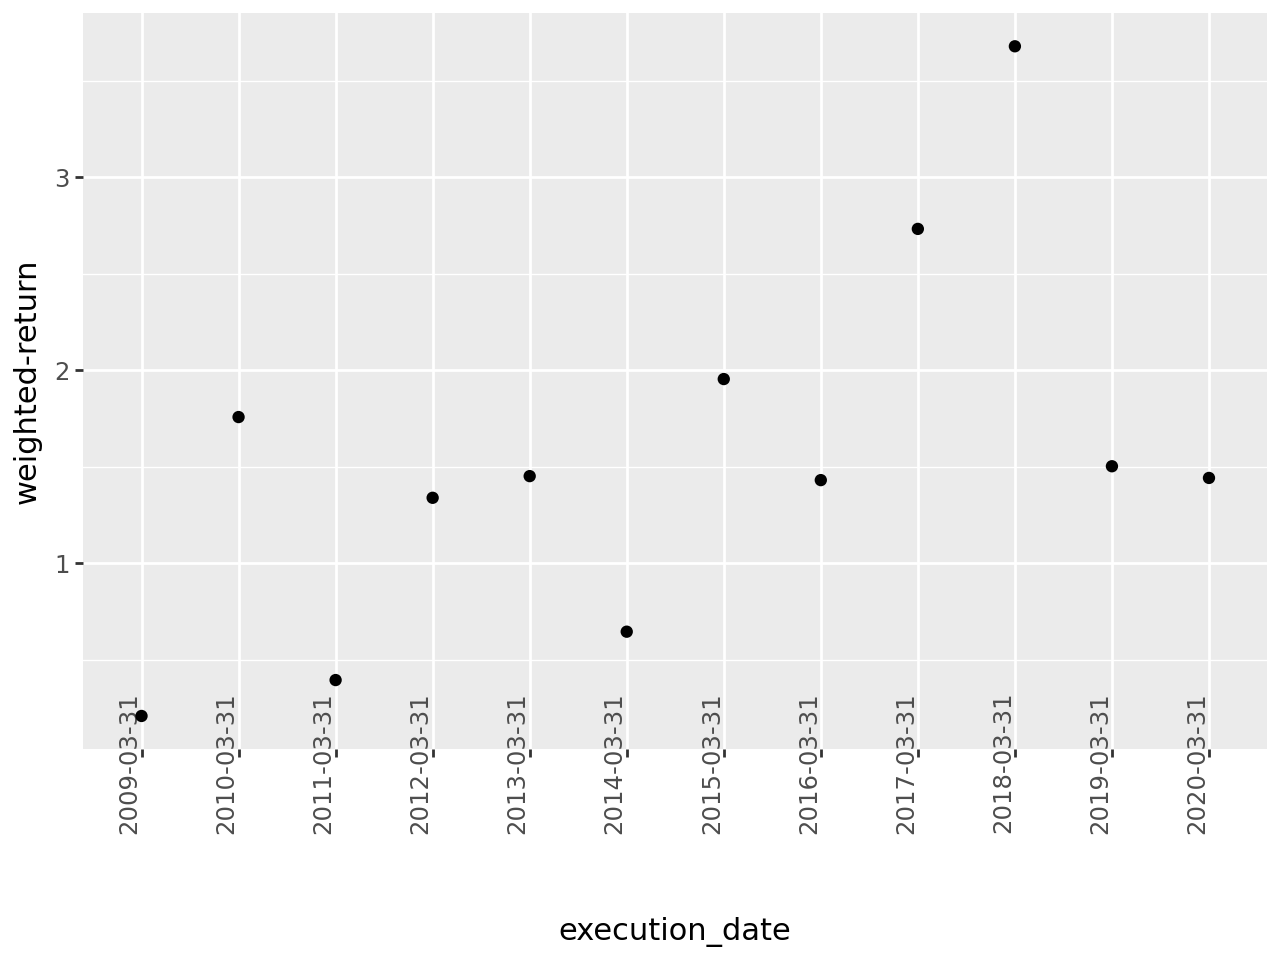

In [243]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We can see that, for validations, the returns are now quite reasonable. Even though there are two peaks, the other execution dates have returns not higher than 0.2 and we also have some negative returns. During training, the returns are still quite high but not has much as at the begining.

#### 4. We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones

My first idea was to use the typical metrics precision, recall, roc_auc, and mae. Buy actually, this is not what was expected. The thing here is that, even tough it is important to have the final business metric (weighted return) in mind, the actual metric the model is trying to minimize is the binary log-loss. Therefore, in order to understand what the model is doing, we should work with this metric, which is closer to the model.

Therefore, we create a function that computes the percentage difference of each metric in each new tree with respect to the value of the metric in the first tree. This way, we will be able to see if the metric is improving or not across trees.

In [244]:
def compute_logloss_differences(eval_result, test_set):
    """Test set should either be 'valid_0' or training"""
    first_tree_loss = eval_result[test_set]['binary_logloss'][0]
    percentage_differences = [(metric - first_tree_loss) / first_tree_loss * 100 for metric in eval_result[test_set]['binary_logloss']]
    return percentage_differences


In [245]:
import seaborn as sns

all_results = {}
all_predicted_tickers_list = []
all_models = {}
percentage_differences_train_all = []
percentage_differences_val_all = []

for execution_date in execution_dates:
    print(execution_date)
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test, test_set = run_model_for_execution_date(execution_date, all_results,
                                                                                                                        all_predicted_tickers_list,
                                                                                                                        all_models, n_trees, learning_rate,
                                                                                                                        False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")
        percentage_differences_train = compute_logloss_differences(all_results[execution_date], 'training')
        percentage_differences_val = compute_logloss_differences(all_results[execution_date], 'valid_0')

        for idx, diff in enumerate(percentage_differences_train):
            percentage_differences_train_all.append({
                'execution_date': execution_date,
                'tree_number': idx,
                'percentage_difference': diff
            })
        for idx, diff in enumerate(percentage_differences_val):
            percentage_differences_val_all.append({
                'execution_date': execution_date,
                'tree_number': idx,
                'percentage_difference': diff
            })

    else:
        print(f"No model returned for execution date: {execution_date}")

# Convert the percentage differences to a DataFrame
percentage_differences_train_df = pd.DataFrame(percentage_differences_train_all)
percentage_differences_val_df = pd.DataFrame(percentage_differences_val_all)

2008-03-31T00:00:00.000000000
No model returned for execution date: 2008-03-31T00:00:00.000000000
2009-03-31T00:00:00.000000000
Model trained for execution date: 2009-03-31T00:00:00.000000000
2010-03-31T00:00:00.000000000
Model trained for execution date: 2010-03-31T00:00:00.000000000
2011-03-31T00:00:00.000000000
Model trained for execution date: 2011-03-31T00:00:00.000000000
2012-03-31T00:00:00.000000000
Model trained for execution date: 2012-03-31T00:00:00.000000000
2013-03-31T00:00:00.000000000
Model trained for execution date: 2013-03-31T00:00:00.000000000
2014-03-31T00:00:00.000000000
Model trained for execution date: 2014-03-31T00:00:00.000000000
2015-03-31T00:00:00.000000000
Model trained for execution date: 2015-03-31T00:00:00.000000000
2016-03-31T00:00:00.000000000
Model trained for execution date: 2016-03-31T00:00:00.000000000
2017-03-31T00:00:00.000000000
Model trained for execution date: 2017-03-31T00:00:00.000000000
2018-03-31T00:00:00.000000000
Model trained for executio

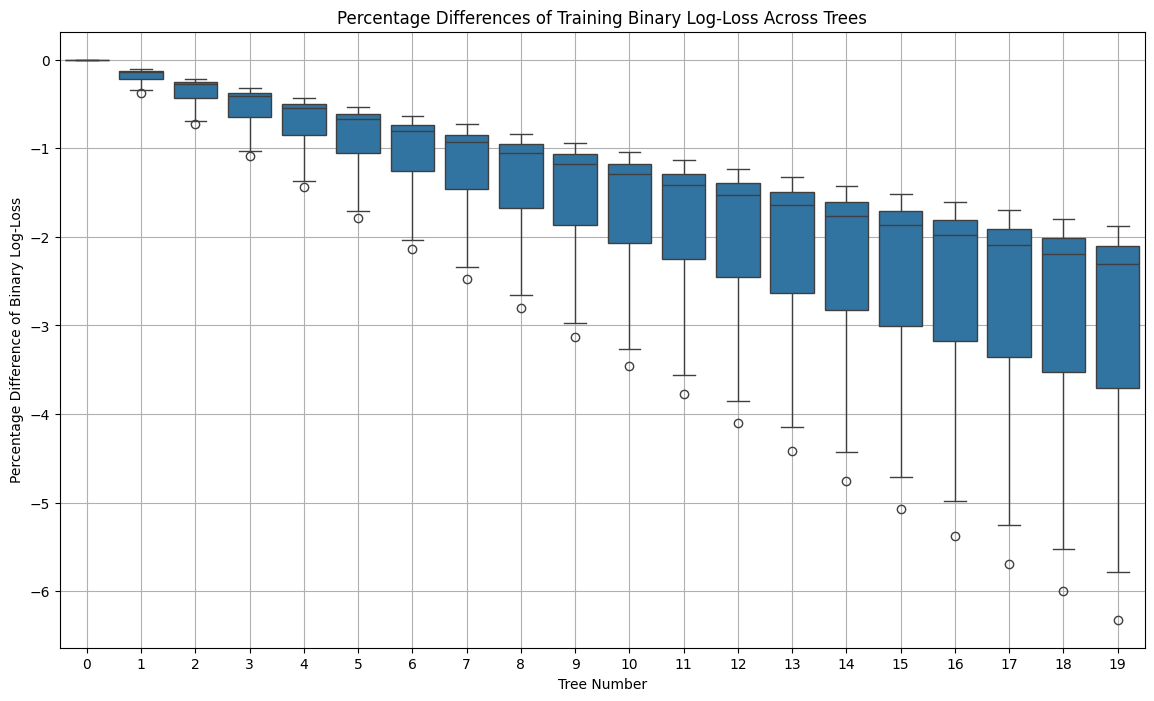

In [246]:
# Create box plots
plt.figure(figsize=(14, 8))
sns.boxplot(x='tree_number', y='percentage_difference', data=percentage_differences_train_df)
plt.xlabel('Tree Number')
plt.ylabel('Percentage Difference of Binary Log-Loss')
plt.title('Percentage Differences of Training Binary Log-Loss Across Trees')
plt.grid()
plt.show()

We can observe that during training the log loss keeps decreasing in a nice way and that the variability increases as more trees are added.

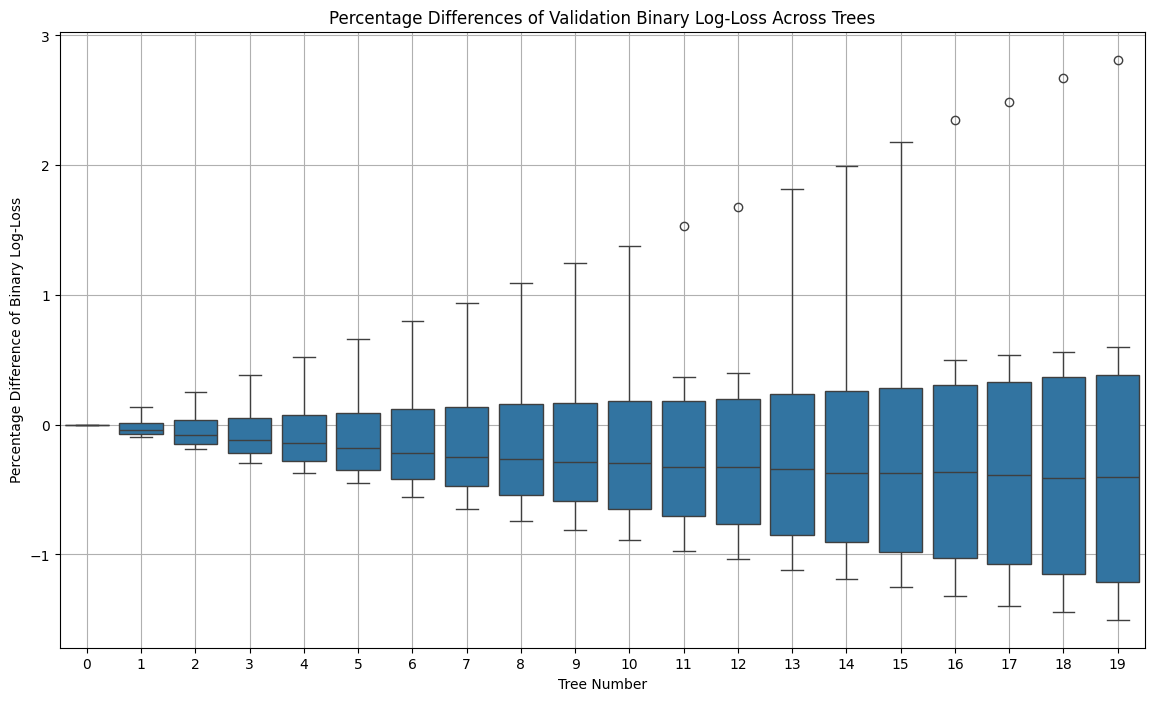

In [247]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='tree_number', y='percentage_difference', data=percentage_differences_val_df)
plt.xlabel('Tree Number')
plt.ylabel('Percentage Difference of Binary Log-Loss')
plt.title('Percentage Differences of Validation Binary Log-Loss Across Trees')
plt.grid()
plt.show()

The box plot analysis reveals that while the model improves with the addition of trees initially, there is a point (more or less 7 trees) after which additional trees introduce more variability and potential overfitting, as even though the mean continues to decrease, it has the drawback of increasing variability. 

#### 6. Try to see if there is a lot of noise between different trainings

When plotting the additional metrics and the returns for the different execution dates (and therefore for the different models) we can observe that it looks like there is noise between the trainings, as the values oscilate a lot.

#### 7 & 8. To simplify, keep only the first tickers in terms of Market Cap & Change the number of quarters to train in the past


In [248]:
minimum_number_of_tickers = 1500

# Number of the quarters in the past to train
n_train_quarters = 20

# number of tickers to make the portfolio
top_n = 5

In [249]:
len(data_set)

38835

In [250]:
execution_dates = np.sort(data_set['execution_date'].unique() )

In [251]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
percentage_differences_train_all = []
percentage_differences_val_all = []

for execution_date in execution_dates:
    print(execution_date)
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test, test_set = run_model_for_execution_date(execution_date, all_results,
                                                                                                                        all_predicted_tickers_list,
                                                                                                                        all_models, n_trees, learning_rate,
                                                                                                                        False)

    if model is not None:
        print(f"Model trained for execution date: {execution_date}")
        percentage_differences_train = compute_logloss_differences(all_results[execution_date], 'training')
        percentage_differences_val = compute_logloss_differences(all_results[execution_date], 'valid_0')

        for idx, diff in enumerate(percentage_differences_train):
            percentage_differences_train_all.append({
                'execution_date': execution_date,
                'tree_number': idx,
                'percentage_difference': diff
            })
        for idx, diff in enumerate(percentage_differences_val):
            percentage_differences_val_all.append({
                'execution_date': execution_date,
                'tree_number': idx,
                'percentage_difference': diff
            })

    else:
        print(f"No model returned for execution date: {execution_date}")

# Convert the percentage differences to a DataFrame
percentage_differences_train_df = pd.DataFrame(percentage_differences_train_all)
percentage_differences_val_df = pd.DataFrame(percentage_differences_val_all)

2008-03-31T00:00:00.000000000
No model returned for execution date: 2008-03-31T00:00:00.000000000
2009-03-31T00:00:00.000000000
Model trained for execution date: 2009-03-31T00:00:00.000000000
2010-03-31T00:00:00.000000000
Model trained for execution date: 2010-03-31T00:00:00.000000000
2011-03-31T00:00:00.000000000
Model trained for execution date: 2011-03-31T00:00:00.000000000
2012-03-31T00:00:00.000000000
Model trained for execution date: 2012-03-31T00:00:00.000000000
2013-03-31T00:00:00.000000000
Model trained for execution date: 2013-03-31T00:00:00.000000000
2014-03-31T00:00:00.000000000
Model trained for execution date: 2014-03-31T00:00:00.000000000
2015-03-31T00:00:00.000000000
Model trained for execution date: 2015-03-31T00:00:00.000000000
2016-03-31T00:00:00.000000000
Model trained for execution date: 2016-03-31T00:00:00.000000000
2017-03-31T00:00:00.000000000
Model trained for execution date: 2017-03-31T00:00:00.000000000
2018-03-31T00:00:00.000000000
Model trained for executio

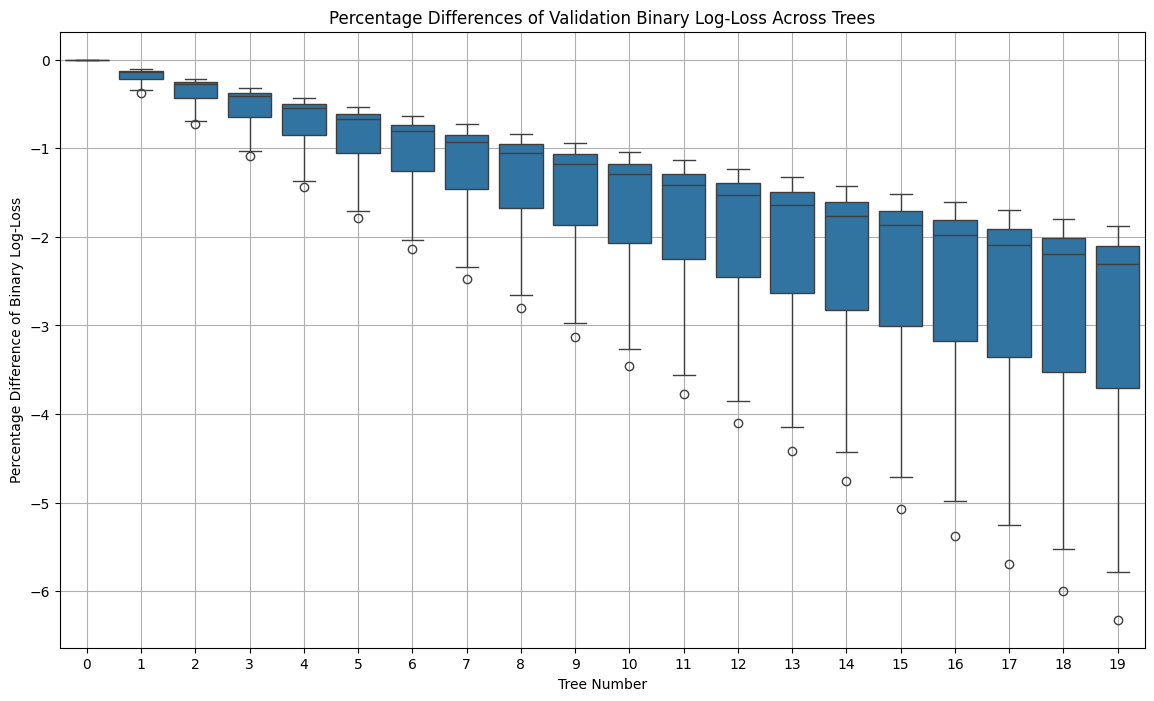

In [252]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='tree_number', y='percentage_difference', data=percentage_differences_train_df)
plt.xlabel('Tree Number')
plt.ylabel('Percentage Difference of Binary Log-Loss')
plt.title('Percentage Differences of Validation Binary Log-Loss Across Trees')
plt.grid()
plt.show()

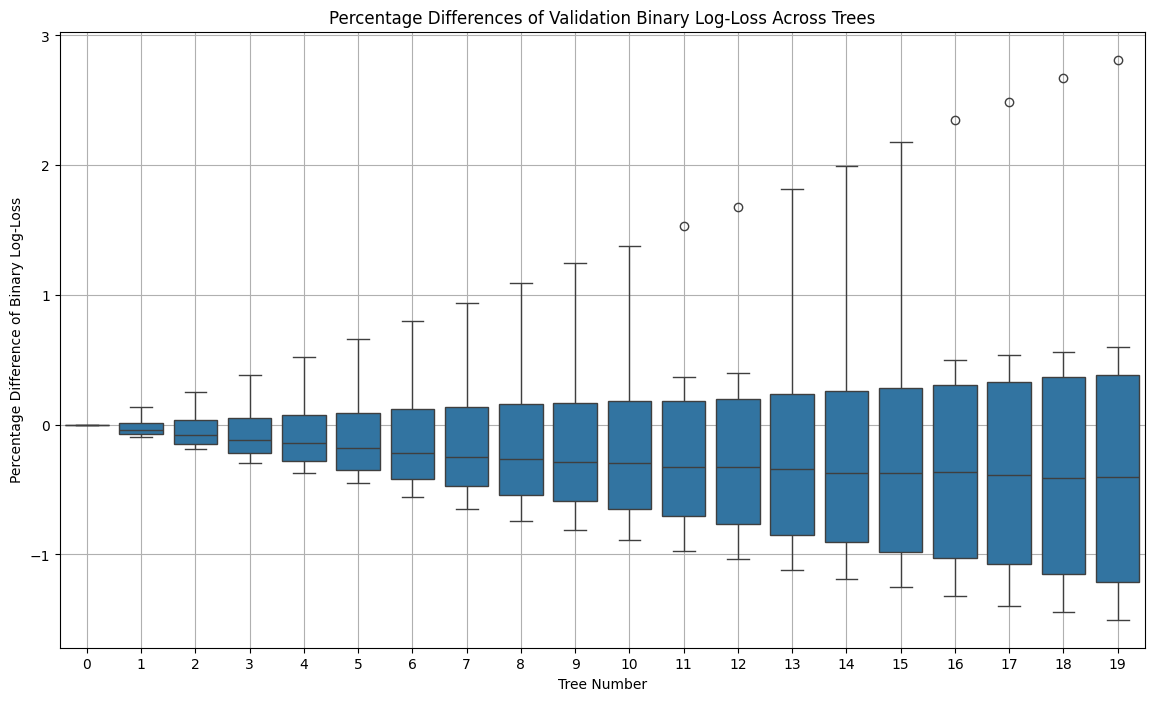

In [253]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='tree_number', y='percentage_difference', data=percentage_differences_val_df)
plt.xlabel('Tree Number')
plt.ylabel('Percentage Difference of Binary Log-Loss')
plt.title('Percentage Differences of Validation Binary Log-Loss Across Trees')
plt.grid()
plt.show()

We can observe the interperation is very similar than before.

In [254]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

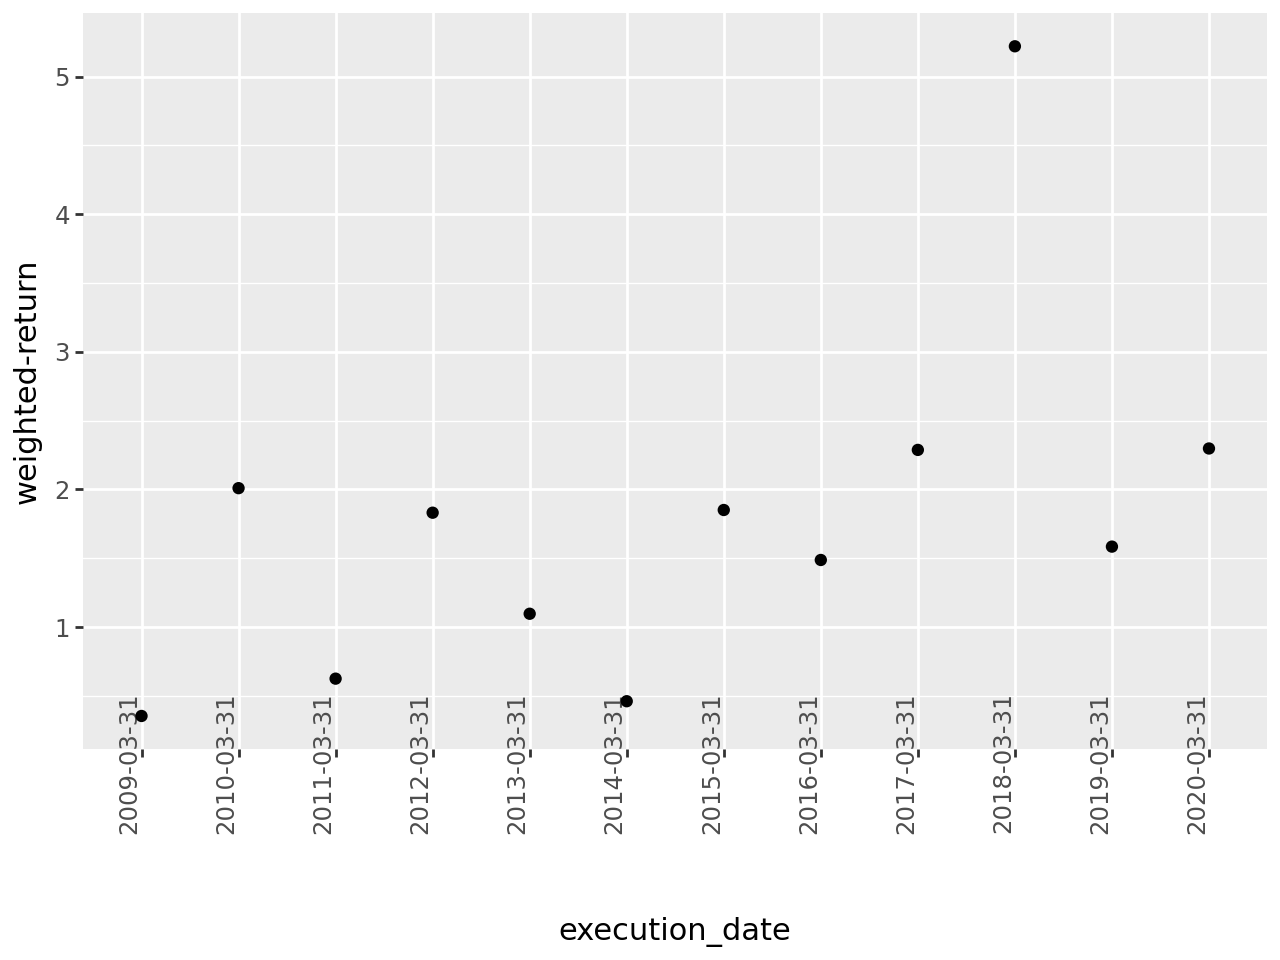

In [255]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

For the validation results, we compare with the benchmark:

In [256]:
test_results_final_tree['type'] = 'Model'
test_results_final_tree['execution_date'] = pd.to_datetime(test_results_final_tree['execution_date'])

combined_data_test = pd.concat([
    benchmark_performance[['execution_date', 'weighted-return', 'type']],
    test_results_final_tree[['execution_date', 'weighted-return', 'type']]
])

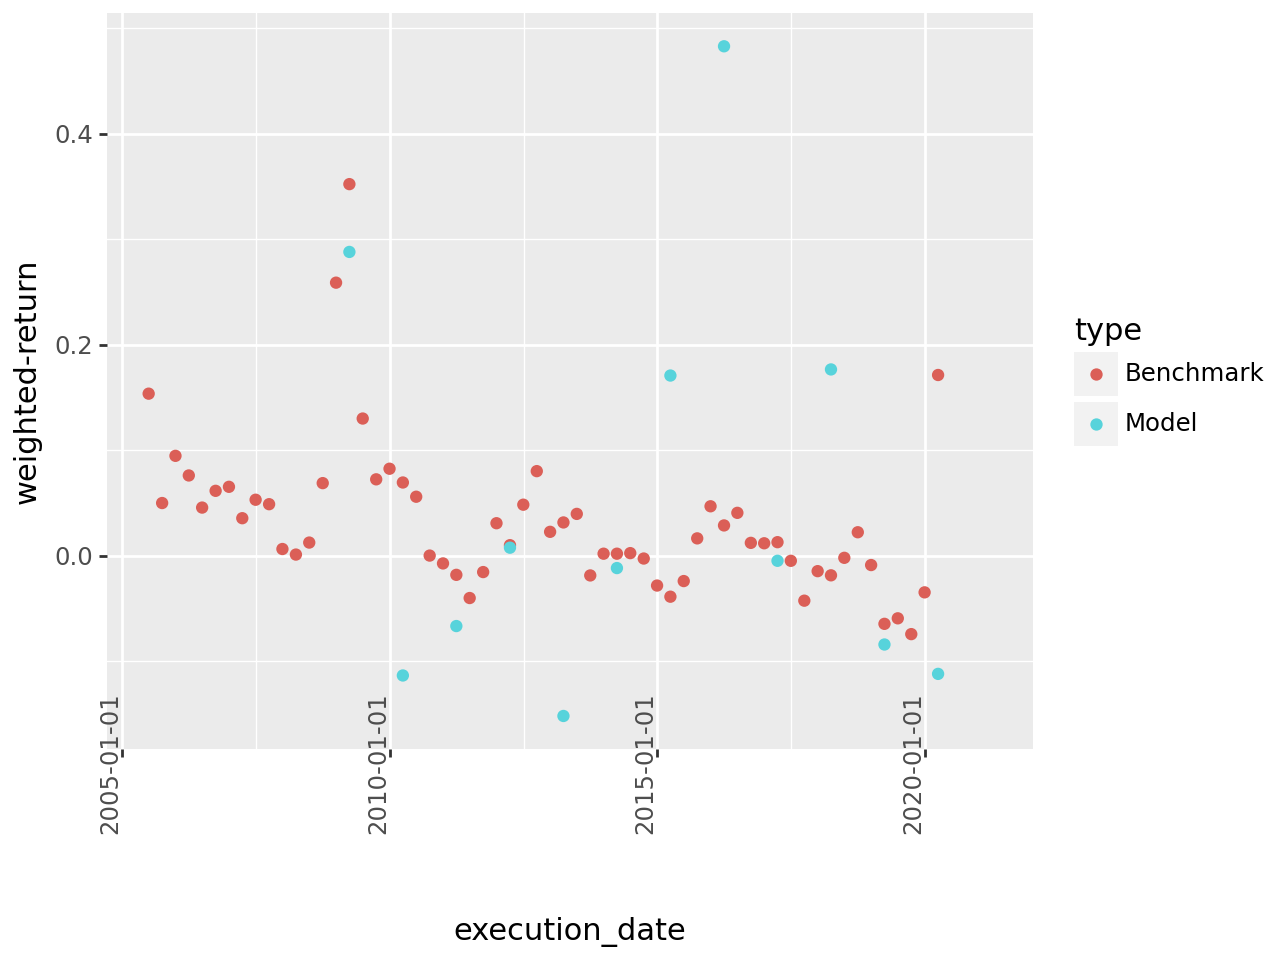

In [257]:
ggplot(combined_data_test) + geom_point(aes(x = "execution_date", y = "weighted-return", color="type")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We can observe that now the returns in validation are more similar to the benchmark and much more reasonable. We can also observe that the model decisions are quite risky, as some tradings result in a negative result. Nevertheless, when the decision is made correctly, the returns are quite high.

Finally, we will also check if these new models have reasonable feature importance.

In [258]:
plots = []
for execution_date, model in all_models.items():
    plot = draw_feature_importance(model, 15)
    plots.append(plot)

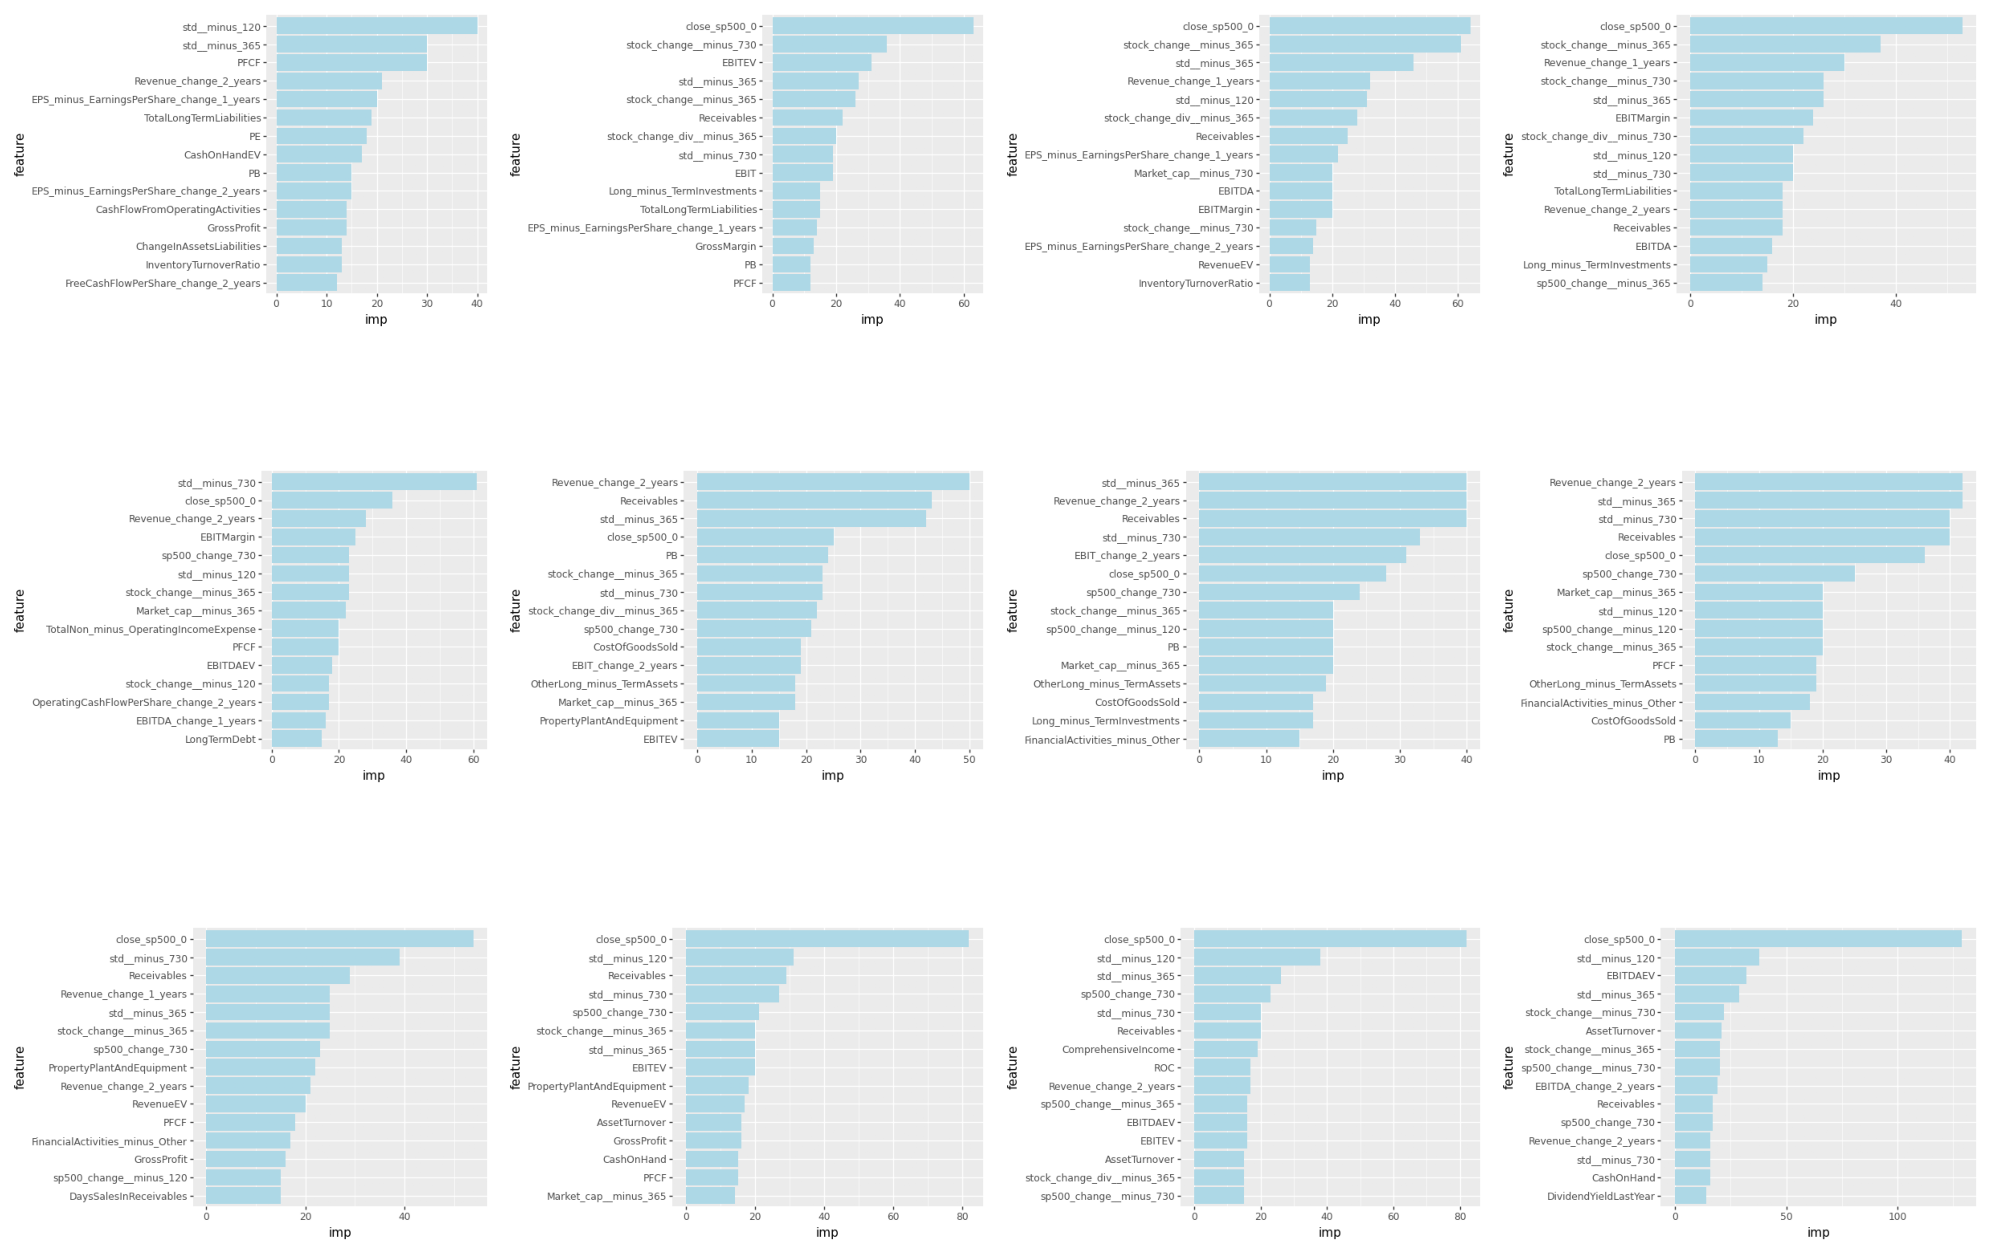

In [259]:
ncols = 4
nrows = (len(plots) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5))

axes = axes.flatten()

# Plot each ggplot in the corresponding subplot
for ax, plot in zip(axes, plots):
    if plot is not None:
        with NamedTemporaryFile(suffix=".png") as tmpfile:
            plot.save(tmpfile.name, width=6, height=4, units='in', dpi=100)
            img = plt.imread(tmpfile.name)
            ax.imshow(img)
            ax.axis('off')
    else:
        ax.axis('off')

# Turn off any remaining empty subplots
for ax in axes[len(plots):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

I believe these results are more resonable now, as the models give importance to feature such as sp500 change, std_minus, or revenue changes.